* [1.Load Data From CSV File](#ld)
* [2.Build a pipeline](#bp)
* [3.Modèles de machine learning](#mml)
* [4.Optimisation du modèle](#om)


In [108]:
#!pip install xgboost

In [109]:
#!pip install lightgbm 

In [110]:
import pandas as pd
import numpy as np

import missingno as msno
import seaborn as sns

import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,StandardScaler

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from  xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from time import time


from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

### Load Data From CSV File<a class="anchor" id="ld"></a>

In [111]:
df = pd.read_csv('prepared_data.csv', sep='\t')
df.head()

,OSEBuildingID,BuildingType,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,tranche_date,BuildingAge,groups_neighborhood,groups_PrimaryPropertyType
0,1,NonResidential,1.0,12,88434,60.0,182.500000,7226362.5,249.98,2.83,tranche_date1,89,Various,Various
1,2,NonResidential,1.0,11,103566,61.0,176.100006,8387933.0,295.86,2.86,tranche_date3,20,Various,Various
2,3,NonResidential,1.0,41,956110,43.0,241.899994,72587024.0,2089.28,2.19,tranche_date2,47,Various,Various
3,5,NonResidential,1.0,10,61320,56.0,216.199997,6794584.0,286.43,4.67,tranche_date1,90,Various,Various
4,8,NonResidential,1.0,18,175580,75.0,211.399994,14172606.0,505.01,2.88,tranche_date3,36,Various,Various


In [112]:
df.shape

(1655, 14)

In [113]:
df.columns

Index(['OSEBuildingID', 'BuildingType', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'ENERGYSTARScore', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'tranche_date', 'BuildingAge', 'groups_neighborhood',
       'groups_PrimaryPropertyType'],
      dtype='object')

In [114]:
cols=['BuildingType', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'ENERGYSTARScore', 'SourceEUI(kBtu/sf)',
        'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'tranche_date', 'BuildingAge', 'groups_neighborhood',
       'groups_PrimaryPropertyType']

In [115]:
df=df[cols]

In [116]:
numercial_cols = [col for col in df.columns if df[col].dtype!="O"]
print(numercial_cols)

['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore', 'SourceEUI(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'BuildingAge']


In [117]:
categorical_cols = [col for col in df.columns if df[col].dtype=="O"]
print(categorical_cols)

['BuildingType', 'tranche_date', 'groups_neighborhood', 'groups_PrimaryPropertyType']


In [118]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus'], dtype=object)

In [119]:
df['groups_neighborhood'].unique()

array(['Various', 'South', 'North', 'Central'], dtype=object)

In [120]:
df['tranche_date'].unique()

array(['tranche_date1', 'tranche_date3', 'tranche_date2', 'tranche_date4'],
      dtype=object)

In [121]:
df['groups_PrimaryPropertyType'].unique()

array(['Various', 'Commerce', 'Health'], dtype=object)

In [122]:
df.shape

(1655, 12)

In [123]:
numercial_cols_for_transformer=list(set(numercial_cols)-set(['TotalGHGEmissions']))

In [124]:
numercial_cols_for_transformer

['SourceEUI(kBtu/sf)',
 'ENERGYSTARScore',
 'GHGEmissionsIntensity',
 'PropertyGFATotal',
 'BuildingAge',
 'NumberofFloors',
 'NumberofBuildings']

## Build a pipeline<a class="anchor" id="bp"></a>

In [125]:
# Create pipelines for numerical and categorical features
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
 #when using sklearn.compose.ColumnTransformer You need to make sure the output column is not included in the data you create your Preprocessing pipeline with
# Create ColumnTransformer to apply pipeline for each column type
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numercial_cols_for_transformer),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [126]:
tx = preprocessor.get_params()['transformers']
feature_names = []
for name,transformer,features in tx:
    try:
        Var = preprocessor.named_transformers_[name].get_feature_names_out().tolist()
    except AttributeError:
        Var = features
    feature_names = feature_names + Var

feature_names

['SourceEUI(kBtu/sf)',
 'ENERGYSTARScore',
 'GHGEmissionsIntensity',
 'PropertyGFATotal',
 'BuildingAge',
 'NumberofFloors',
 'NumberofBuildings',
 'BuildingType',
 'tranche_date',
 'groups_neighborhood',
 'groups_PrimaryPropertyType']

In [127]:
y=df[['TotalGHGEmissions']]
y= StandardScaler().fit_transform(y)
features=list(set(cols)-set(['TotalGHGEmissions']))
X=df[features]

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## 3.Idée pour choisir le meilleur modèle

In [129]:
regressors = [LinearRegression(),ElasticNet(),RandomForestRegressor(),SVR(),XGBRegressor(),LGBMRegressor(),Ridge(),Lasso()]

In [130]:
for model in regressors:
    start = time()
    pip = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    
    pip.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = pip.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
   
    print("\tMean squared error:", mean_squared_error(y_test, y_pred))
    print("\tRMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

LinearRegression()
	Training time: 0.099s
	Prediction time: 0.144s
	Mean squared error: 0.4706565945074267
	RMSE: 0.6860441636712805
	R2 score: 0.38467891871550053

ElasticNet()
	Training time: 0.078s
	Prediction time: 0.016s
	Mean squared error: 0.7468040421641507
	RMSE: 0.8641782467547715
	R2 score: 0.023652752145111866

RandomForestRegressor()
	Training time: 1.464s
	Prediction time: 0.031s
	Mean squared error: 0.8786409935119233
	RMSE: 0.9373585191973898
	R2 score: -0.14870657821009736

SVR()
	Training time: 0.156s
	Prediction time: 0.016s
	Mean squared error: 0.4695640010595877
	RMSE: 0.6852474013519407
	R2 score: 0.38610733975447975

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
         

**Note**
<br>
Dans la suite on va travailler sur les 3 modèles retenus ayant les 4 premiers meilleurs coefficiet de détermination r2 notamment LinearRegression,Ridge,SVR et LGBMRegressor.

## 4.Modèles de machine learning choisis<a class="anchor" id="mml"></a>

In [131]:
def f_performance(pip):
    #pip.fit(X_train,y_train)
  
    
    print('******************')
    #Check MSE and RMSE

    y_pred = pip.predict(X_test)
    print(f'MSE : {mean_squared_error(y_test, y_pred):.3f}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
    print(f'R2 : {r2_score(y_test, y_pred):.3f}')

### 4.1.Regression linéaire

In [132]:
#LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, 
#and the targets predicted by the linear approximation.

In [133]:

clf_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LinearRegression())]
)



In [134]:
clf_lr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SourceEUI(kBtu/sf)',
                                                   'ENERGYSTARScore',
                                                   'GHGEmissionsIntensity',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   'NumberofFloors',
                                                   'NumberofBuildings']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BuildingType',
                                

### 4.1.1.Indicateurs de performance

In [135]:
f_performance(clf_lr)

******************
MSE : 0.471
RMSE : 0.686
R2 : 0.385


### 4.1.2.Coéfficients du modèle

In [136]:

clf_lr.named_steps['model'].intercept_

array([0.19553985])

In [137]:
def f_coeff(pip):
    # Putting together the coefficient and their corresponding variable names
    #pip.fit(X_train,y_train)
    df_coefficient = pd.DataFrame()
    df_coefficient["Columns"] = feature_names
    df_coefficient['Estimated Coefficient '] = pd.Series(pip.named_steps['model'].coef_.flatten())
    return df_coefficient
    #print(lreg_coefficient)

In [138]:
f_coeff(clf_lr)

,Columns,Estimated Coefficient
0,SourceEUI(kBtu/sf),-0.105161
1,ENERGYSTARScore,0.026740
2,GHGEmissionsIntensity,0.551296
3,PropertyGFATotal,0.505797
4,BuildingAge,0.014840
5,NumberofFloors,-0.171982
6,NumberofBuildings,0.098392
7,BuildingType,0.516923
8,tranche_date,-0.088962
9,groups_neighborhood,-0.335836


In [139]:
font = {
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

In [140]:
def f_plot_coeff(pip_reg):
    # plotting the coefficient score
    

    fig, ax = plt.subplots(figsize =(25, 10))
 
    color =['tab:gray', 'tab:blue', 'tab:orange',
            'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
            'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',
            'tab:orange', 'tab:green', 'tab:blue', 'tab:olive']
    
    df_coefficient=f_coeff(pip_reg)
    ax.bar(df_coefficient["Columns"],
    df_coefficient['Estimated Coefficient '],
       color=color
           )

    ax.spines['bottom'].set_position('zero')
 
    plt.style.use('ggplot')
    plt.xticks(rotation=30, ha='right')
    plt.show()

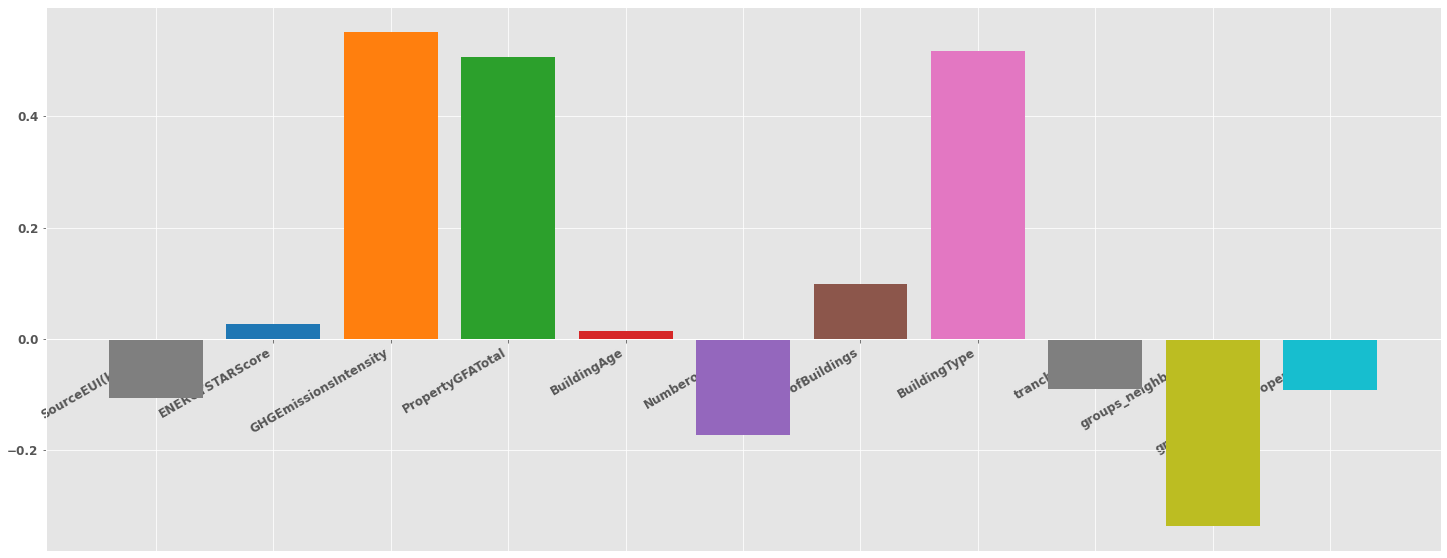

In [141]:
f_plot_coeff(clf_lr)

**Observations**
<br>
On peut remarquer que les features les plus importants sont: 'GHGEmissionsIntensity','BuildingType_Campus' et 'PropertyGFATotal'

### 4.1.3.Optimisation du modèle

#### Cross validation

In [142]:

scores = cross_val_score(clf_lr, X, y, cv=10,scoring='r2')#coefficient of determination (pr défaut). how well the regression model fits the observed data.a higher coefficient indicates a better fit for the model.
scores


array([  0.3411361 ,   0.39695666,  -0.38122074,   0.46855445,
       -10.59807641,  -1.0145701 ,  -0.02434956,   0.22009336,
        -3.51019306,   0.48126262])

In [143]:
print(" mean ofR2= %0.2f" % scores.mean())

 mean ofR2= -1.36


#### Ajustement des paramètres en utilisant gridsearch

In [144]:
#Paramètres à ajuster
LinearRegression().get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

In [145]:
#normalize:If True, the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm
#positive:When set to True, forces the coefficients to be positive. This option is only supported for dense arrays
#copy_X: If True, X will be copied
#n_jobs:

In [146]:
from sklearn.model_selection import train_test_split, GridSearchCV
#LinearRegression().get_params().keys()
param_grid = {
    
    "model__fit_intercept": [True, False],
    "model__copy_X": [True, False],
    "model__positive": [True, False],
    "model__normalize": [True, False],
    #"model": [LinearRegression()]
}

grid_search = GridSearchCV(clf_lr, param_grid, cv=10)


In [147]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SourceEUI(kBtu/sf)',
                                                                          'ENERGYSTARScore',
                                                                          'GHGEmissionsIntensity',
                                                                          'PropertyGFATotal',
                                                                          'BuildingAge',
                                                                          'NumberofFloors',
                                                                      

In [148]:
df_1 = pd.DataFrame(grid_search.cv_results_).set_index('rank_test_score').sort_index()
df_1.shape

(16, 21)

In [149]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__copy_X,param_model__fit_intercept,param_model__normalize,param_model__positive,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.044381,0.081201,0.009367,0.007649,True,True,True,True,"{'model__copy_X': True, 'model__fit_intercept'...",0.638638,...,-2.358686,-2.228505,0.035222,0.469137,0.205773,0.378961,0.467284,-0.248395,1.048130,7
1,0.015625,0.000002,0.007811,0.007811,True,True,True,False,"{'model__copy_X': True, 'model__fit_intercept'...",0.613541,...,-3.049500,-2.567275,0.200924,0.504800,0.195860,0.389241,0.084382,-0.382032,1.239675,15
2,0.015322,0.003406,0.007050,0.007373,True,True,False,True,"{'model__copy_X': True, 'model__fit_intercept'...",0.638638,...,-2.358686,-2.228505,0.035222,0.469137,0.205773,0.378961,0.467284,-0.248395,1.048130,5
3,0.017400,0.005534,0.005894,0.006779,True,True,False,False,"{'model__copy_X': True, 'model__fit_intercept'...",0.614297,...,-3.049500,-2.567275,0.214066,0.504800,0.195860,0.389059,0.083142,-0.376911,1.240751,9
4,0.015624,0.006987,0.006250,0.007654,True,False,True,True,"{'model__copy_X': True, 'model__fit_intercept'...",0.662582,...,-2.284490,-2.275786,-0.000997,0.468866,0.213103,0.380741,0.527094,-0.243716,1.047579,1
5,0.014062,0.004687,0.004687,0.007159,True,False,True,False,"{'model__copy_X': True, 'model__fit_intercept'...",0.614297,...,-3.049500,-2.567275,0.214066,0.504800,0.195860,0.389059,0.083142,-0.376911,1.240751,11
6,0.015622,0.000006,0.007812,0.007812,True,False,False,True,"{'model__copy_X': True, 'model__fit_intercept'...",0.662582,...,-2.284490,-2.275786,-0.000997,0.468866,0.213103,0.380741,0.527094,-0.243716,1.047579,1
7,0.014063,0.004688,0.007812,0.007812,True,False,False,False,"{'model__copy_X': True, 'model__fit_intercept'...",0.614297,...,-3.049500,-2.567275,0.214066,0.504800,0.195860,0.389059,0.083142,-0.376911,1.240751,11
8,0.017414,0.002216,0.008683,0.005511,False,True,True,True,"{'model__copy_X': False, 'model__fit_intercept...",0.638638,...,-2.358686,-2.228505,0.035222,0.469137,0.205773,0.378961,0.467284,-0.248395,1.048130,7
9,0.014648,0.007274,0.006327,0.007752,False,True,True,False,"{'model__copy_X': False, 'model__fit_intercept...",0.613541,...,-3.049500,-2.567275,0.200924,0.504800,0.195860,0.389241,0.084382,-0.382032,1.239675,15


In [150]:
grid_search.best_params_

{'model__copy_X': True,
 'model__fit_intercept': False,
 'model__normalize': True,
 'model__positive': True}

In [151]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.479
RMSE : 0.692
R2 : 0.373


**Observations**
<br>

pas bcp de paramètre avec la regression linéaire regardons la regression polynomial

In [152]:
numeric_transformer_pol = Pipeline(
    steps=[("scaler", StandardScaler()),('poly', PolynomialFeatures(degree=5))]
)

#categorical_transformer = OneHotEncoder(handle_unknown="ignore")
 #when using sklearn.compose.ColumnTransformer You need to make sure the output column is not included in the data you create your Preprocessing pipeline with
# Create ColumnTransformer to apply pipeline for each column type
preprocessor_pol = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_pol, numercial_cols_for_transformer),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [153]:

clf_pr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LinearRegression())])
clf_pr.fit(X_train,y_train)
f_performance(clf_pr)


******************
MSE : 0.471
RMSE : 0.686
R2 : 0.385


### 4.2.Ridge regression

In [154]:
clf_rr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", Ridge())]
)
clf_rr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SourceEUI(kBtu/sf)',
                                                   'ENERGYSTARScore',
                                                   'GHGEmissionsIntensity',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   'NumberofFloors',
                                                   'NumberofBuildings']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BuildingType',
                                

### 4.2.1.Indicateurs de performance

In [155]:
f_performance(clf_rr)

******************
MSE : 0.469
RMSE : 0.685
R2 : 0.387


 ### 4.2.2.Coéfficients du modèle

In [156]:
clf_rr.named_steps['model'].intercept_

array([0.18577373])

In [157]:
f_coeff(clf_rr)


,Columns,Estimated Coefficient
0,SourceEUI(kBtu/sf),-0.104736
1,ENERGYSTARScore,0.026640
2,GHGEmissionsIntensity,0.551247
3,PropertyGFATotal,0.505766
4,BuildingAge,0.013856
5,NumberofFloors,-0.171717
6,NumberofBuildings,0.100346
7,BuildingType,0.487703
8,tranche_date,-0.081057
9,groups_neighborhood,-0.323550


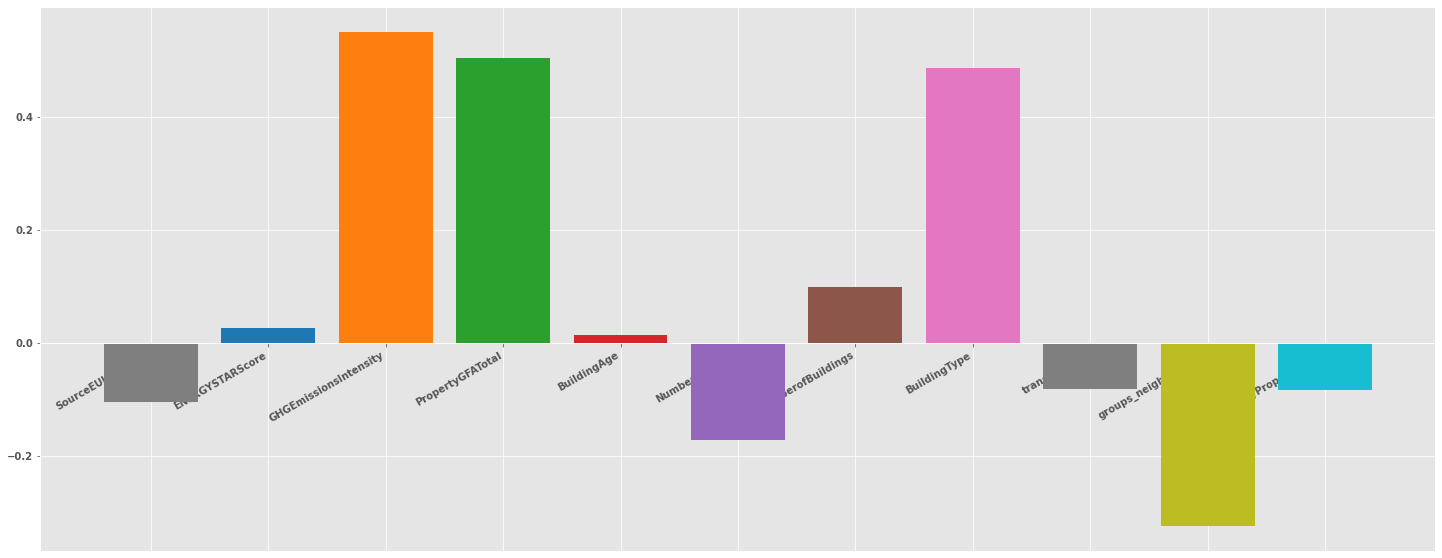

In [158]:
f_plot_coeff(clf_rr)

**Observations**
<br>
Pareil pour la regression linéaire,
on peut remarquer que les features les plus importants sont: 'GHGEmissionsIntensity','BuildingType_Campus' et 'PropertyGFATotal

### 4.2.3.Optimisation du modèle

#### Cross validation

In [159]:
scores = cross_val_score(clf_rr, X, y, cv=10,scoring='r2')#coefficient of determination (pr défaut). how well the regression model fits the observed data.a higher coefficient indicates a better fit for the model.
scores

array([  0.34167814,   0.39710286,  -0.37512197,   0.46933741,
       -10.5536692 ,  -0.99231776,  -0.0228202 ,   0.22120908,
        -3.49750761,   0.48104778])

In [160]:

print(" mean of  R2= %0.2f" % scores.mean())

 mean of  R2= -1.35


#### Ajustement des paramètres 

In [161]:
Ridge().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol'])

In [162]:
#{'alpha': [1,0.1,0.01,0.001,0.0001,0] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

In [163]:
param_grid = {
    
    "model__alpha": [1,0.1,0.01,0.001,0.0001,0,5,10],
    "model__solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    "model__fit_intercept": [True, False],
    "model__normalize": [True, False],
    #"model": [LinearRegression()]
}

grid_search = GridSearchCV(clf_rr, param_grid, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SourceEUI(kBtu/sf)',
                                                                          'ENERGYSTARScore',
                                                                          'GHGEmissionsIntensity',
                                                                          'PropertyGFATotal',
                                                                          'BuildingAge',
                                                                          'NumberofFloors',
                                                                      

In [164]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__fit_intercept,param_model__normalize,param_model__solver,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016073,0.001382,0.008935,0.008954,1,True,True,auto,"{'model__alpha': 1, 'model__fit_intercept': Tr...",0.610061,...,-0.540935,0.106248,0.489555,0.323930,0.435229,0.219086,0.596780,0.292430,0.317464,2
1,0.021078,0.014003,0.006249,0.007654,1,True,True,svd,"{'model__alpha': 1, 'model__fit_intercept': Tr...",0.610061,...,-0.540935,0.106248,0.489555,0.323930,0.435229,0.219086,0.596780,0.292430,0.317464,1
2,0.014139,0.004718,0.006251,0.007656,1,True,True,cholesky,"{'model__alpha': 1, 'model__fit_intercept': Tr...",0.610061,...,-0.540935,0.106248,0.489555,0.323930,0.435229,0.219086,0.596780,0.292430,0.317464,2
3,0.031842,0.030005,0.016420,0.005426,1,True,True,lsqr,"{'model__alpha': 1, 'model__fit_intercept': Tr...",0.609948,...,-0.542374,0.105326,0.489160,0.323690,0.435400,0.219197,0.596198,0.292240,0.317784,7
4,0.043621,0.027573,0.013582,0.009891,1,True,True,sparse_cg,"{'model__alpha': 1, 'model__fit_intercept': Tr...",0.610097,...,-0.541205,0.106186,0.489816,0.323953,0.435268,0.219091,0.596371,0.292334,0.317527,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.017190,0.004680,0.007808,0.007808,10,False,False,lsqr,"{'model__alpha': 10, 'model__fit_intercept': F...",0.631297,...,-2.792728,-2.460096,0.194214,0.510192,0.210947,0.388554,0.125238,-0.329504,1.171552,43
252,0.018748,0.006249,0.007811,0.007811,10,False,False,sparse_cg,"{'model__alpha': 10, 'model__fit_intercept': F...",0.631695,...,-2.792728,-2.458456,0.195011,0.510019,0.209923,0.387533,0.125238,-0.329466,1.171198,40
253,0.039057,0.007812,0.012502,0.006251,10,False,False,sag,"{'model__alpha': 10, 'model__fit_intercept': F...",0.631522,...,-2.786698,-2.459599,0.193378,0.510363,0.209813,0.387568,0.125820,-0.329164,1.170098,38
254,0.070326,0.012634,0.009376,0.007655,10,False,False,saga,"{'model__alpha': 10, 'model__fit_intercept': F...",0.631785,...,-2.782029,-2.462339,0.191459,0.510681,0.209744,0.388093,0.125479,-0.329111,1.169600,31


In [165]:
grid_search.best_params_


{'model__alpha': 1,
 'model__fit_intercept': True,
 'model__normalize': True,
 'model__solver': 'svd'}

In [166]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.473
RMSE : 0.688
R2 : 0.381


##### 

### 4.3.SVR

In [167]:
clf_svr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", SVR())]
)
clf_svr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SourceEUI(kBtu/sf)',
                                                   'ENERGYSTARScore',
                                                   'GHGEmissionsIntensity',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   'NumberofFloors',
                                                   'NumberofBuildings']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BuildingType',
                                

### 4.3.1.Indicateurs de performance

In [168]:
f_performance(clf_svr)

******************
MSE : 0.470
RMSE : 0.685
R2 : 0.386


### 4.3.2.Coefficients du modèle

In [169]:

clf_svr.named_steps['model'].intercept_

array([0.795951])

In [170]:
clf_svr.n_features_in_

11

In [171]:
clf_svr.feature_names_in_

array(['ENERGYSTARScore', 'SourceEUI(kBtu/sf)', 'GHGEmissionsIntensity',
       'groups_neighborhood', 'tranche_date', 'PropertyGFATotal',
       'BuildingAge', 'NumberofFloors', 'NumberofBuildings',
       'BuildingType', 'groups_PrimaryPropertyType'], dtype=object)

### 4.3.3.Optimisation du modèle

#### Cross validation

In [172]:
scores = cross_val_score(clf_svr, X, y, cv=10,scoring='r2')#coefficient of determination (pr défaut). how well the regression model fits the observed data.a higher coefficient indicates a better fit for the model.
scores

array([0.1067452 , 0.27082677, 0.92425675, 0.13844431, 0.63654428,
       0.40525179, 0.70935438, 0.36433316, 0.78579017, 0.39705361])

In [173]:
print(" mean of  R2= %0.2f" % scores.mean())

 mean of  R2= 0.47


#### Ajustement des paramètres

In [174]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [175]:
param_grid = {
    
    "model__C": [1,0.1,0.01,0.001,0.0001,0.00001,0.00001,5,20,50,100],
    "model__epsilon": [0.0001, 0.001, 0.1, 1, 0.005, 0.0009],
    #"model__kernel": [True, False],
    #"model__gamma": [True, False],
    
}

grid_search = GridSearchCV(clf_svr, param_grid, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SourceEUI(kBtu/sf)',
                                                                          'ENERGYSTARScore',
                                                                          'GHGEmissionsIntensity',
                                                                          'PropertyGFATotal',
                                                                          'BuildingAge',
                                                                          'NumberofFloors',
                                                                      

In [176]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.519315,0.086379,0.034449,6.215566e-03,1,0.0001,"{'model__C': 1, 'model__epsilon': 0.0001}",0.598168,0.780367,0.875315,0.885045,0.905003,0.796914,0.107543,0.501948,0.075486,0.734784,0.626057,0.293259,24
1,0.385951,0.010006,0.034387,6.245639e-03,1,0.001,"{'model__C': 1, 'model__epsilon': 0.001}",0.599288,0.779981,0.875541,0.884193,0.904300,0.797632,0.108278,0.502640,0.075986,0.734881,0.626272,0.292898,22
2,0.046881,0.000034,0.015626,9.725608e-07,1,0.1,"{'model__C': 1, 'model__epsilon': 0.1}",0.601241,0.732884,0.819440,0.793313,0.831222,0.756171,0.132126,0.505154,0.091798,0.716111,0.597946,0.260892,25
3,0.028123,0.006250,0.006249,7.654013e-03,1,1,"{'model__C': 1, 'model__epsilon': 1}",-1.381866,-2.463920,-0.925809,-5.127392,-7.919970,-1.233886,-0.037015,-1.158768,0.042172,-3.373232,-2.357969,2.376984,60
4,0.210933,0.007797,0.025013,7.664062e-03,1,0.005,"{'model__C': 1, 'model__epsilon': 0.005}",0.602803,0.778335,0.875923,0.878714,0.901909,0.798995,0.111019,0.505240,0.078281,0.735310,0.626653,0.291179,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,4.078395,0.294469,0.032811,4.686873e-03,100,0.001,"{'model__C': 100, 'model__epsilon': 0.001}",0.981529,0.942583,0.812449,0.369935,0.827579,0.928097,0.442175,0.910891,0.252154,0.951411,0.741880,0.261759,5
62,0.071866,0.007654,0.012503,6.251586e-03,100,0.1,"{'model__C': 100, 'model__epsilon': 0.1}",0.967005,0.876212,0.652264,-0.071442,0.656272,0.794662,0.480364,0.878202,0.277627,0.913865,0.642503,0.313319,19
63,0.026561,0.007160,0.009388,7.665126e-03,100,1,"{'model__C': 100, 'model__epsilon': 1}",0.051160,-0.580173,-0.480638,-3.648960,-4.079802,-0.406516,0.402467,-0.203622,0.229888,-0.841047,-0.955724,1.500825,56
64,0.775039,0.072331,0.028138,6.255561e-03,100,0.005,"{'model__C': 100, 'model__epsilon': 0.005}",0.981725,0.936174,0.784283,0.283675,0.792028,0.919866,0.453835,0.907912,0.259482,0.954521,0.727350,0.269735,15


In [177]:
grid_search.best_params_

{'model__C': 100, 'model__epsilon': 0.0001}

In [178]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.230
RMSE : 0.479
R2 : 0.700


### 4.4.LGBMRegressor

In [179]:
clf_lgb = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LGBMRegressor())]
)
clf_lgb.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SourceEUI(kBtu/sf)',
                                                   'ENERGYSTARScore',
                                                   'GHGEmissionsIntensity',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   'NumberofFloors',
                                                   'NumberofBuildings']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BuildingType',
                                